# 稠密模型 Dense Model

稠密模型指模型结构中所有参数和计算路径在每次前向计算中都会被激活 \
原始的Transformer里用的是FFN，但是现在的LLM都希望能动态控制信息流通【带门控机制的FFN】

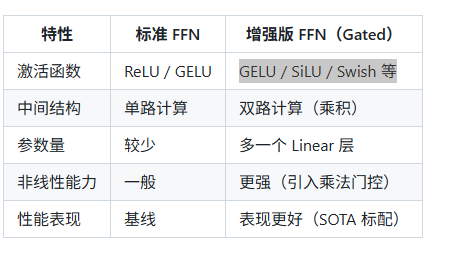
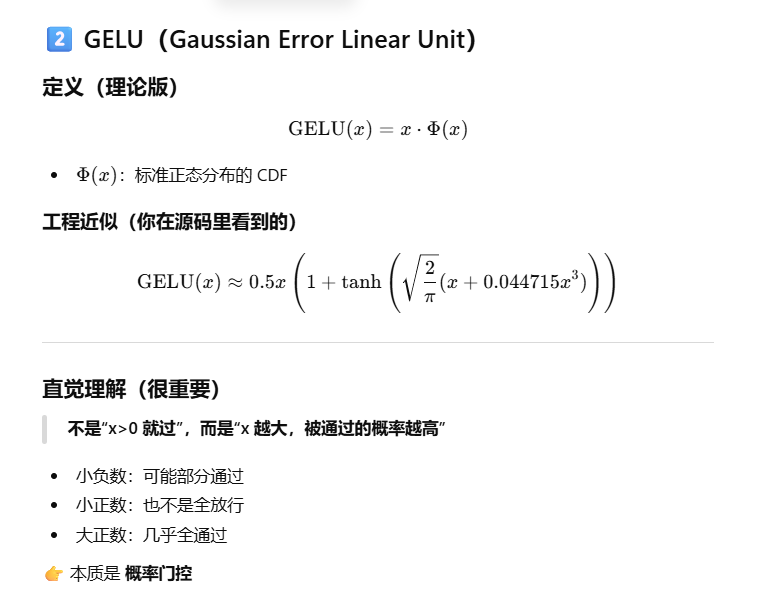
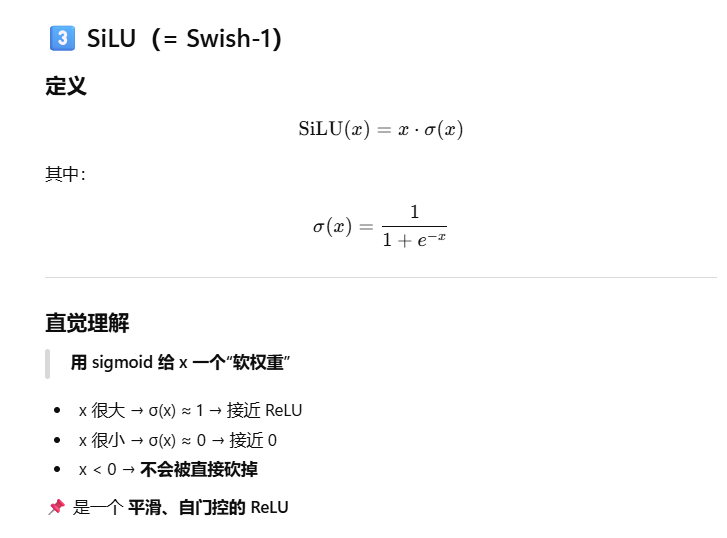
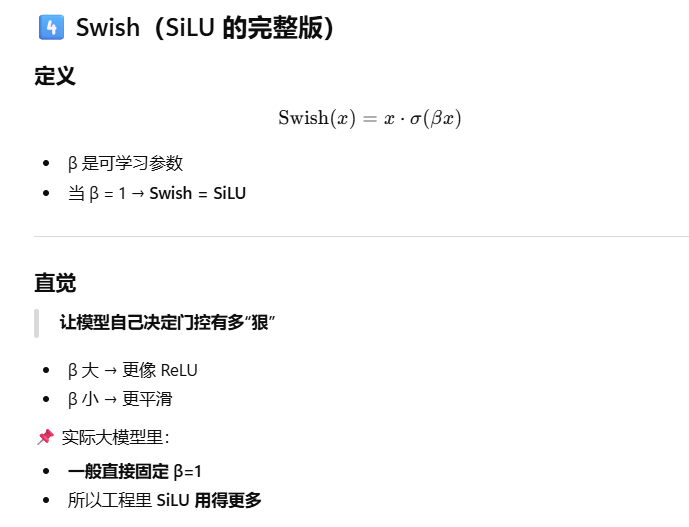

In [1]:
# 增强版FFN
import torch
import torch.nn as nn
import torch.nn.functional as F

# 激活函数映射字典
ACT2FN = {
    "relu": F.relu,
    "gelu": F.gelu,
    "silu": F.silu
}

class FeedForward(nn.Module):
    def __init__(self, config: dict):
        super().__init__()
        if config["intermediate_size"] is None:
            intermediate_size = int(config["hidden_size"] * 8 / 3)
            # 为了GPU并行计算，中间维度会向上取整到64的倍数
            config["intermediate_size"] = 64 * ((intermediate_size + 64 - 1) // 64)

        self.gate_proj = nn.Linear(config["hidden_size"], config["intermediate_size"], bias=False)
        self.down_proj = nn.Linear(config["intermediate_size"], config["hidden_size"], bias=False)
        self.up_proj = nn.Linear(config["hidden_size"], config["intermediate_size"], bias=False)
        self.dropout = nn.Dropout(config["dropout"])
        self.act_fn = ACT2FN[config["hidden_act"]]

    def forward(self, x):
        return self.dropout(
            self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))
        )

config = {
    "hidden_size": 512,
    "intermediate_size": None,
    "dropout": 0.1, 
    "hidden_act": "silu",
}

# 创建模型和输入
ffn = FeedForward(config)
x = torch.randn(2, 16, 512) # [batch_size, seq_len, hidden_size]

out = ffn(x)
print("Output shape: ", out.shape)

d:\miniconda3\envs\minimind\lib\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Output shape:  torch.Size([2, 16, 512])


# 稀疏模型 MoE

模型参数很多，用MoE每次只激活其中一部分【top-k】，通过门控机制选择专家进行预测，最后组合专家输出

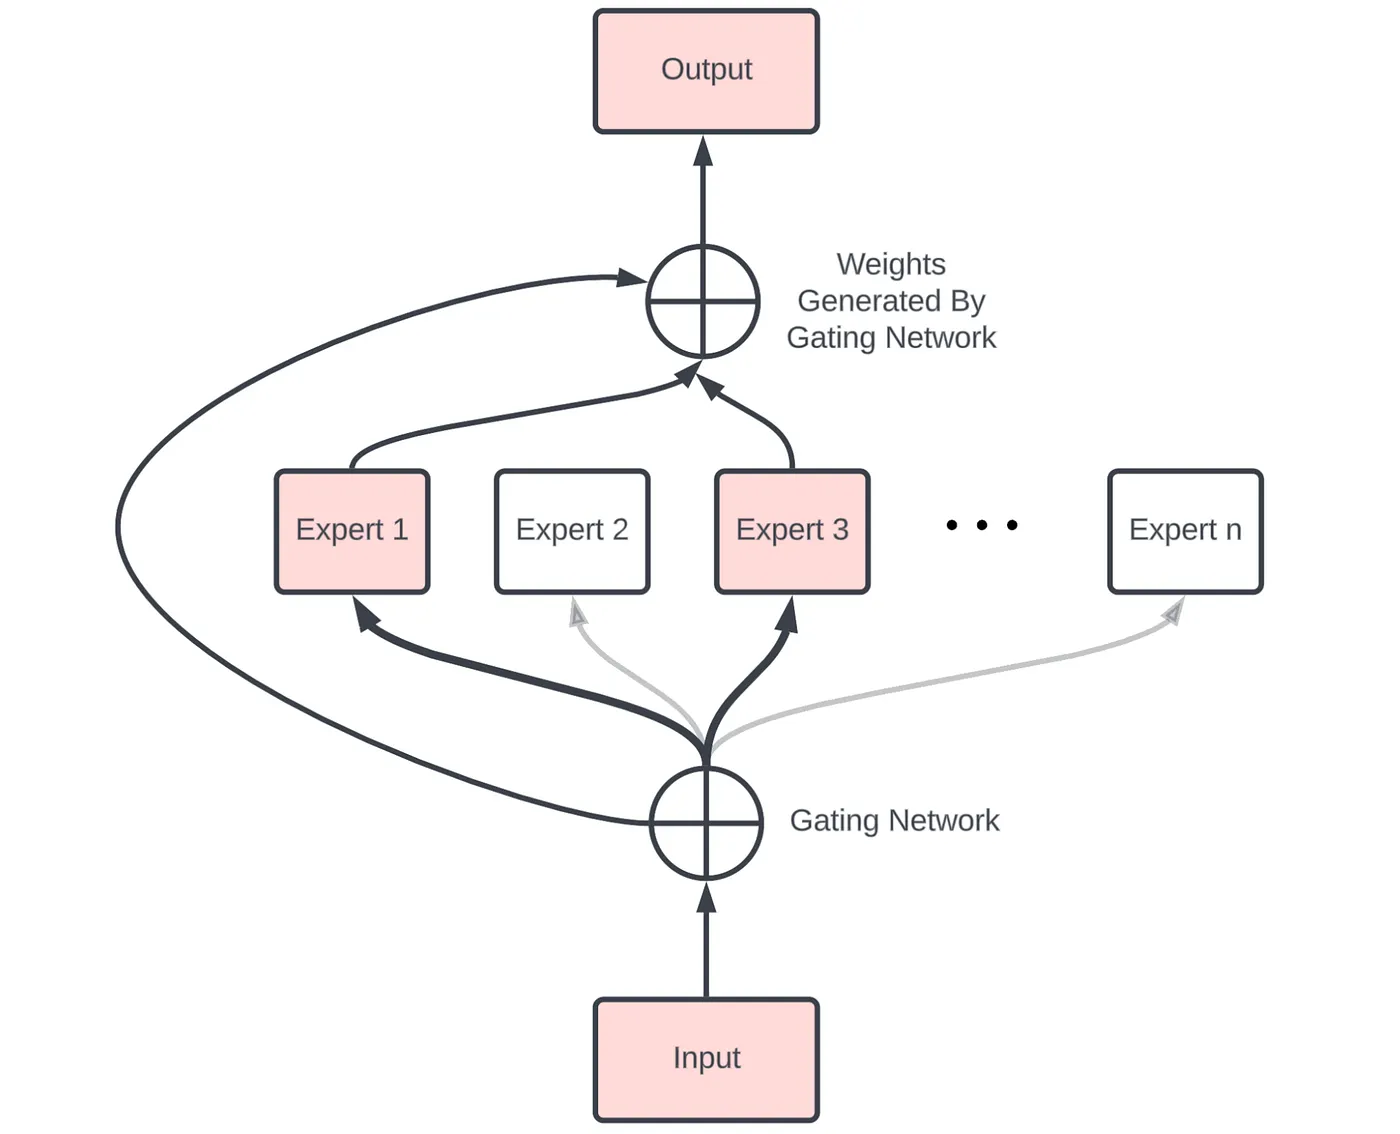

MoE流程
1. 对每个 token，使用 MoEGate 打分，选择 top-k 个专家（例如 k=2）
2. 只将 token 输入给这 k 个专家（repeat_interleave）
3. 每个专家输出后加权求和（使用 gate 输出的 softmax 权重）
4. 返回合并后的输出

In [ ]:
class MOEFeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # 初始化专家网络
        self.experts = nn.ModuleList([
            FeedForward(config)
            for _ in range(config.n_routed_experts)
        ])

        # 初始化门控网络
        self.gate = MoEGate(config)

        # 可选：共享专家网络（作用于每一个token）
        if config.n_shared_experts > 0:
            self.shared_experts = nn.ModuleList([
                FeedForward(config)
                for _ in range(config.n_shared_experts)
            ])
    def forward(self, x):
        # x: [bsz, seq_len, hidden_size]
        identity = x # 用于residual加上共享专家输出
        orig_shape = x.shape
        bsz, seq_len, _ = x.shape

        # 1. 门控阶段：选择top-k个专家作为每个token的路由
        topk_idx, topk_weight, aux_loss = self.gate(x) # topk_idx每个token选的专家id，weight就是权重，aux_loss是辅助损失避免有的专家太闲有的太忙
        # topk_idx, topk_weight: [bsz * seq_len, top_k]

        # 2. Flatten token维度，准备并行处理
        x = x.view(-1, x.shape[-1])
        # x: [bsz * seq_len, hidden_size]

        flat_topk_idx = topk_idx.view(-1)

        if self.training:
            # 3. 训练阶段：每个token被复制topk次，送给不同的专家
            x = x.repeat_interleave(self.config.num_experts_per_tok, dim=0) # 按照dim维去复制

            # 收集每个专家处理后的结果
            y = torch.empty_like(x, dtype=torch.float16) # 一个和x形状一样的空张量

            # 遍历每个专家，将其处理分配给它们的token
            for i, expert in enumerate(self.experts):
                # 找出所有分配给第i个专家的token
                mask = (flat_topk_idx == i)
                x_i = x[mask] # 取出这些token [num_token_i, hidden_size]

                if x_i.shape[0] > 0: # 有token才处理
                    y[mask] = expert(x_i).to(y.dtype) # 专家处理token，存到y对应的位置 [num_token_i, hidden_size]
            
            # 恢复top_k维度，根据gate分数加权平均
            y = y.view(*topk_weight.shape, -1) # [bsz * seq_len, top_k, hidden_size]
            y = (y * topk_weight.unsqueeze(-1)).sum(dim=1) # 在top_k维度进行加权求和 [bsz * seq_len, hidden_size]

            # 恢复原始形状
            y = y.view(*orig_shape)
        else:
            # 4. 推理阶段：使用高效推理模式（不复制token，按专家分组）
            topk_weight = topk_weight.view(-1, 1) # [bsz * seq_len, top_k] --> [bsz * seq_len * top_k, 1]
            y = self.moe_infer(x, flat_topk_idx, topk_weight)
            y = y.view(*orig_shape)
        
        # 5. 加上共享专家的输出（可选）
        if self.config.n_shared_experts > 0:
            for expert in self.shared_experts:
                y = y + expert(identity) # 共享专家处理原始输入结果加到y上
        
        self.aux_loss = aux_loss # 训练时要把这个门控产生的辅助损失加到总损失里
        return y

@torch.no_grad() # 推理时不计算梯度，省内存
def moe_infer(self, x, flat_expert_indices, flat_expert_weights):
    # 推理阶段MoE的前向传播，按照专家编号将token分组，分别送入对应专家中计算后合并
    # x: [bsz * seq_len, hidden_size]
    # flat_expert_indices: [(bsz * seq_len) * top_k]
    # flat_expert_weights: [(bsz * seq_len) * top_k , 1]

    expert_cache = torch.zeros_like(x) # 初始化输出缓存，和x形状一样，全0

    # 1. 按专家ID排序：把分配给同一个专家的token排在一起【从小到大】
    idxs = flat_expert_indices.argsort() 

    # 2. 统计每个专家的token数量，累加后切分
    tokens_per_expert = flat_expert_indices.bincount().cpu().numpy().cumsum(0)
    # tokens_per_expert[i]表示第i个专家前面（由其他专家）累计处理了多少个token

    # 3. 找排序后的token对应的原始token位置
    token_idxs = idxs // self.config.num_experts_per_tok

    # 4. 遍历每个专家，分组处理
    for i, end_idx in enumerate(tokens_per_expert):
        start_idx = 0 if i == 0 else tokens_per_expert[i-1]
        if start_idx == end_idx:
            continue # 该专家没有被分配token

        expert = self.experts[i] # 获取第i个专家的FFN模块

        # 5. 获取分配给第i个专家的token原始位置索引
        exp_token_idx = token_idxs[start_idx:end_idx]

        # 6. 取出这些token的原始表示
        expert_tokens = x[exp_token_idx]

        # 7. 专家处理token
        expert_out = expert(expert_tokens).to(expert_cache.dtype) # [num_token_i, hidden_size]

        # 8. 乘以门控权重
        # [num_token_i, hidden_size] * [num_token_i, 1] --> [num_token_i, hidden_size]
        expert_out.mul_(flat_expert_weights[idxs[start_idx: end_idx]]) # mul_逐元素原地矩阵乘法

        # 9. 累加到输出缓存中，支持一个token被多个专家处理后结果叠加
        # scatter_add_函数就是按给定的index，把src的每一行加到expert_cache指定的行上
        # index要求shape必须和src一样
        # scatter_add_工业上可以一次性并行完成所有累加，比用for 循环速度快
        expert_cache.scatter_add_(
            dim = 0,
            index = exp_token_idx.view(-1, 1).repeat(1, x.shape[-1]), # 索引的拓展维度
            src = expert_out
        )
        return expert_cache  # [bsz * seq_len, hidden_size]

# MoE的负载均衡

可能打分的时候总是偏向给某几个专家打分，导致这些过载的专家会比负载较轻的专家学习得更快，导致过载专家和负载较轻专家的梯度在幅度和方向上可能会发散，使得训练过程难以收敛 \
计算每个专家`平均打分*实际负载`，如果偏高，那么这个乘积就作为一项loss进行惩罚

In [ ]:
class MoEGate(nn.Module):
    def __init__(self.config):
        super().__init__()
        self.config = config
        self.top_k = config.num_experts_per_tok # 每个token分配的专家数
        self.n_routed_experts = config.n_routed_experts # 总可选专家数

        self.scoring_func = config.scoring_func # 评分函数（只支持softmax）
        self.alpha = config.aux_loss_alpha # 辅助损失的权重
        self.seq_aux = config.seq_aux # 是否按每个样本计算辅助损失

        self.norm_topk_prob = config.norm_topk_prob # 是否对top-k权重归一化
        self.gating_dim = config.hidden_size # gating输入维度

        self.weight = nn.Parameter(torch.empty((self.n_routed_experts, self.gating_dim))) # 初始化门控的权重参数
        self.reset_parameters()
    
    def reset_parameters(self) -> None:
        import torch.nn.init as init
        import math
        init.kaiming_uniform_(self.weight, a=math.sqrt(5)) # 权重初始化函数
    
    def forward(self, hidden_states):
        # Aegs: hidden_states: [bsz, seq_len, hidden_dim]
        # Returns
        # topk_idx: [bsz * seq_len, top_k]
        # topk_weight: [bsz * seq_len, top_k]
        # aux_loss: scalar
        bsz, seq_len, h = hidden_states.shape
        hidden_states = hidden_states.view(-1, h) # 把所有token排成一列，方便计算

        logits = F.linear(hidden_states, self.weight, None) # 计算每个token对每个专家的打分

        if self.scoring_func == 'softmax':
            scores = logits.softmax(dim=-1) # 对专家维度做归一化
        else:
            raise NotImplementedError(f'Insupportable scoring function for MoE gating: {self.scoring_func}')
        
        topk_weight, topk_idx = torch.topk(scores, k=self.top_k, dim=-1, sorted=False) # 选topk个概率最高的专家，返回权重和索引

        if self.top_k > 1 and self.norm_topk_prob:
            # 如果有多个专家且需要归一化
            denominator = topk_weight.sum(dim=-1, keepdim=True) + 1e-20 # 避免除0
            topk_weight = topk_weight / denominator # [bsz * seq_len, top_k]

        # 辅助损失让专家负载更均匀
        if self.training and self.alpha > 0.0:
            scores_for_aux = scores # 复制所有专家的概率分数
            aux_topk = self.top_k # 每个token选的专家数
            topk_idx_for_aux_loss = topk_idx.view(bsz, -1) 

            if self.seq_aux:
                # 按每个样本计算辅助损失
                scores_for_seq_aux = scores_for_aux.view(bsz, seq_len, -1)

                # 统计每个样本中，每个专家被选了多少次
                ce = torch.zeros(bsz, self.n_routed_experts, device=hidden_states.device)

                # 统计每个专家的被选次数
                ce.scatter_add_(
                    dim = 1,
                    index = topk_idx_for_aux_loss,
                    src = torch.one(bsz, seq_len * aux_topk, device=hidden_states.device)
                ).div_(seq_len * aux_topk / self.n_routed_experts)

                # 计算辅助损失
                # 频率 * 平均打分取平均乘权重
                aux_loss = (ce * scores_for_seq_aux.mean(dim=1)).sum(dim=1).mean()*self.alpha
            else:
                # 不按样本，按整个批次计算辅助损失
                # one-hot编码每个token被选中的expert
                mask_ce = F.one_hot(
                    topk_idx_for_aux_loss.view(-1), # [bsz*seq_len*top_k] flatten后的所有expert索引
                    num_classes=self.n_routed_experts # expert数量
                )
                ce = mask_ce.float().mean(0) # 每个专家的被选频率
                Pi = scores_for_aux.mean(0) # 所有token对每个专家的平均打分
                fi = ce * self.n_routed_experts # 计算负载比：频率 × 专家数 → 理想值为1
                aux_loss = (Pi * fi).sum()*self.alpha # Pi: 平均打分 * fi: 实际负载高的 expert 会导致更大的 loss
        else:
            # 不训练/权重为0，辅助损失设为0
            aux_loss = 0
        return topk_idx, topk_weight, aux_loss